In [ ]:
from code_manager.llm import llm
from code_manager.tools import search_code,project_structure

tools = [search_code, project_structure]

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
# highlight-next-line
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [ ]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [ ]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

In [ ]:
simulation

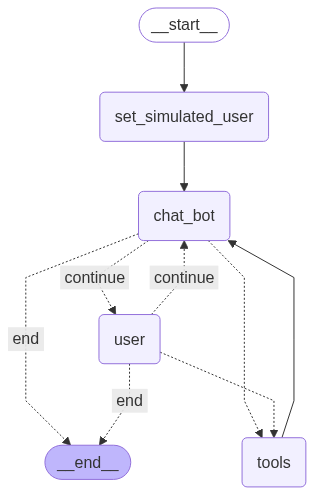

In [3]:
from IPython.display import Image, display

try:
    display(Image(simulation.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.prompts import ChatPromptTemplate
prompt_user = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a assistant that helps simulate a user."),
            ("assistant", "You are a assistant that helps simulate a user."),
            ("user",prompt),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

simulated_user = prompt_user | llm

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            assistant_response = value["messages"][-1].content
            print("Assistant:", assistant_response)
    return assistant_response

while True:
    try:
        user_input = simulated_user.invoke({"messages":})
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        assistant_response = stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

In [1]:
i=9

In [2]:
import json
with open(f"outputs/test{i}_output.json","r") as f:
    data = json.load(f)

query = data['plan']
recorded_actions = data['recorded_steps']
testcase = data['testcase']


# prompt = f"""## 🔍 **Prompt: Function Identification and Verification**

# You will be given a **query** and a set of **recorded actions**.

# You have access to two tools:

# 1. **Code Search Tool** – Use this to search the codebase using the natural language query.
# 2. **Codebase Structure Tool** – Use this to explore the full file/folder structure of the codebase.

# ---

# ### 🎯 **Your Task**

# Use both tools to locate the most relevant function(s) that match the query.

# You **must verify whether the function truly corresponds to the query**, taking into account the **recorded actions**. These actions help disambiguate between similar functions by showing which **page**, **component**, or **step** was actually interacted with.

# You should also identify and validate any **step definitions** that use these functions. This confirms how and where the function is used in **end-to-end flows or tests**.

# ---

# ### ✅ **Verification Checklist**

# For each candidate function, validate the following:

# #### 1. **Relevance**

# * [ ] Does the **function name** or **docstring** clearly relate to the query?
# * [ ] Is the function located in a file/module matching the page/component mentioned or implied in the recorded actions?

# #### 2. **Behavior Matching**

# * [ ] Does the **function logic** match the behavior described in the query?
# * [ ] Do its arguments, side effects, or return values align with the intent of the query?

# #### 3. **Contextual Usage**

# * [ ] Is this function invoked in a flow or page involved in the **recorded actions**?
# * [ ] Can we confirm the **component/page** from which this function is called?

# #### 4. **Step Definitions**

# * [ ] Are there **step definitions** (e.g. from BDD frameworks like Behave/Cucumber) that use this function?
# * [ ] Do the step definitions match the **intent** of the query and the **sequence** in the recorded actions?
# * [ ] Can we trace usage of the function in step files or hooks, and does that confirm its purpose?

# #### 5. **Comparison with Alternatives**

# * [ ] Are there other similar functions? If so, explain **why this function is the best match**.
# * [ ] Is there any **ambiguity or uncertainty**? If yes, clearly explain it and how you handled it.

# ---

# ### 📥 **Input**

# * **Query:** `{query}`
# * **Recorded Actions:** `{recorded_actions}`
# * **Testcase:** `{testcase}`
# ---

# ### 📤 **Output**

# * The best-matching function(s)
# * Matched step definitions (if any)
# * A structured explanation using the checklist above
# """

# prompt = f"""## 🔍 **Prompt: Function Identification and Verification**

# You will be given a **query** and a set of **recorded actions**.

# You have access to two tools:

# 1. **Code Search Tool** – Use this to search the codebase using the natural language query.  
# 2. **Codebase Structure Tool** – Use this to explore the full file/folder structure of the codebase.

# ---

# ### 🎯 **Your Task**

# Use both tools to locate the most relevant function(s) that match the **Query**.  
# Verify each candidate against the **Recorded Actions** and the **Testcase** to ensure it truly implements the intended behavior.  
# Also identify any step definitions (e.g., BDD steps) that invoke these functions, confirming end-to-end usage.

# ---

# ### 📥 **Input**

# * **Query:** `{query}`  
# * **Recorded Actions:** `{recorded_actions}`  
# * **Testcase:** `{testcase}`  

# ---

# ### 📤 **Strict Output Requirement**

# > **You **must**** produce **only** the sections listed below, **in the exact order**, with **exactly** the same headings and markdown syntax. **Do not** add, remove, rename, or reorder any sections or include any other commentary or extraneous text.  

# ---

# ### 📤 **Output Format**

# ## 🏆 Best-Matching Functions and Step Definitions

# 1. **[Function Title]**  
#    - **File:** `[path/to/file]`  
#    - **Class/Function:** `[ClassName or functionName]`  
#    - **Purpose:** `[brief description of what it does]`

# *(Repeat for each best match)*

# ---

# ## ✅ Verification Checklist

# ### 1. Relevance
# - **Function name/docstring:** `[how it matches the Query]`  
# - **Location match:** `[file/module matches Recorded Actions]`

# ### 2. Behavior Matching
# - **Logic alignment:** `[does its code implement the described behavior?]`  
# - **Arguments/Return values:** `[do inputs/outputs align with intent?]`

# ### 3. Contextual Usage
# - **Invocations in flows:** `[where/how it’s called in the Testcase]`  
# - **Component/page context:** `[matches page or component from Recorded Actions]`

# ### 4. Step Definitions
# - **Step file & annotation:** `[e.g. src/test/...StepDefs.java and the @When/@Then text]`  
# - **Mapping to functions:** `[which function each step invokes]`

# ### 5. Comparison with Alternatives
# - **Other candidates:** `[list any similar functions found]`  
# - **Rationale:** `[why this one is the best match]`  
# - **Ambiguities handled:** `[note any uncertainties and your resolution]`

# ---

# ## 📝 Summary Table

# | Step/Action              | Page Class         | Method/Field            | Step Definition                   |
# |--------------------------|--------------------|-------------------------|-----------------------------------|
# | `[Action description]`   | `[ClassName]`      | `[methodName or field]` | `[@Annotation("…")] → function()` |

# *(One row per action in the Testcase)*

# ---

# ## 📦 Base Class and WebDriver

# - **Base Class:** `[class name & file path for shared functionality]`  
# - **WebDriver:** `[driver instance location and usage file]`

# ---

# ## 🟢 Conclusion

# Provide a concise summary confirming that **all** required functions and step definitions were found, are relevant, and correctly map to the **Query**, **Recorded Actions**, and **Testcase**.
# """

prompt = f"""## 🔍 **Prompt: Function Identification and Verification**

You will be given a **query** and a set of **recorded actions**.

You have access to two tools:

1. **Code Search Tool** – Use this to search the codebase using the natural language query.  
2. **Codebase Structure Tool** – Use this to explore the full file/folder structure of the codebase.
3. - You have a tool `file_reader` with you which can give you the code of the files which are mentioned in the answer for analysation.

---

### 🎯 **Your Task**

Use both tools to locate the most relevant function(s) that match the **Query**.  
Verify each candidate against the **Recorded Actions** and the **Testcase** to ensure it truly implements the intended behavior.  
Also identify any step definitions (e.g., BDD steps) that invoke these functions, confirming end-to-end usage.

---

### 📥 **Input**

* **Query:** `{query}`  
* **Recorded Actions:** `{recorded_actions}`  
* **Testcase:** `{testcase}`  

---

### 📤 **Strict Output Requirement**

> **You **must**** produce **only** the sections listed below, **in the exact order**, with **exactly** the same headings and markdown syntax. **Do not** add, remove, rename, or reorder any sections or include any other commentary or extraneous text.  

---

### 📤 **Output Format**

## 🏆 Best-Matching Functions and Step Definitions

1. **[Function Title]**  
   - **File:** `[path/to/file]`  
   - **Class/Function:** `[ClassName or functionName]`  
   - **Purpose:** `[brief description of what it does]`

*(Repeat for each best match)*

---

## ✅ Verification Checklist

### 1. Relevance
- **Function name/docstring:** `[how it matches the Query]`  
- **Location match:** `[file/module matches Recorded Actions]`

### 2. Behavior Matching
- **Logic alignment:** `[does its code implement the described behavior?]`  
- **Arguments/Return values:** `[do inputs/outputs align with intent?]`

### 3. Contextual Usage
- **Invocations in flows:** `[where/how it’s called in the Testcase]`  
- **Component/page context:** `[matches page or component from Recorded Actions]`

### 4. Step Definitions
For each relevant step definition, include:  
- **File & Annotation:** `[e.g. src/test/...StepDefs.java and the @When/@Then text]`  
- **Mapping to Functions:** `[which function each step invokes]`  
- **Code:**  
  ```java
  // Paste the full snippet of the step definition method here
````

### 5. Comparison with Alternatives

* **Other candidates:** `[list any similar functions found]`
* **Rationale:** `[why this one is the best match]`
* **Ambiguities handled:** `[note any uncertainties and your resolution]`

---

## 📝 Summary Table

| Step/Action            | Page Class    | Method/Field            | Step Definition                   |
| ---------------------- | ------------- | ----------------------- | --------------------------------- |
| `[Action description]` | `[ClassName]` | `[methodName or field]` | `[@Annotation("…")] → function()` |

*(One row per action in the Testcase)*

---

## 📦 Base Class and WebDriver

* **Base Class:** `[class name & file path for shared functionality]`
* **WebDriver:** `[driver instance location and usage file]`

---

## 🟢 Conclusion

Provide a concise summary confirming that **all** required functions and step definitions were found, are relevant, and correctly map to the **Query**, **Recorded Actions**, and **Testcase**.
"""


In [3]:
print(testcase)

1. Navigate to https://test11.ewealthmanager.com/ewmLogin/account/login?errorCode=1004&returnUrl=L0NoYW5nZVJvbGU= and enter username "ssoABRALC" and password "QAAdminUser_33a", then click "SIGN IN".
2. On the Change Role page, select the "Agents" radio button and click "Continue".
3. Click the "Financial Planning" menu item.
4. Click the "MoneyGuide" link.
5. Click the "Business Consulting" menu item.
6. Click the "Marketing" menu item.
7. Click the "Service Center" menu item.
8. Click the "Account Wizard" menu item.
9. Click the "Service Center" link under custodial services and forms.


In [4]:
prompt

'## 🔍 **Prompt: Function Identification and Verification**\n\nYou will be given a **query** and a set of **recorded actions**.\n\nYou have access to two tools:\n\n1. **Code Search Tool** – Use this to search the codebase using the natural language query.  \n2. **Codebase Structure Tool** – Use this to explore the full file/folder structure of the codebase.\n3. - You have a tool `file_reader` with you which can give you the code of the files which are mentioned in the answer for analysation.\n\n---\n\n### 🎯 **Your Task**\n\nUse both tools to locate the most relevant function(s) that match the **Query**.  \nVerify each candidate against the **Recorded Actions** and the **Testcase** to ensure it truly implements the intended behavior.  \nAlso identify any step definitions (e.g., BDD steps) that invoke these functions, confirming end-to-end usage.\n\n---\n\n### 📥 **Input**\n\n* **Query:** `["Enter text \'ssoABRALC\' into the input field with id \'okta-signin-username\' using the Selenium d

In [5]:
from code_manager.subgraph.react_llm2 import react_agent

simulation = await react_agent(
    initial_message=prompt,
    system_prompt_template="""
You are a helpful assistant that helps simulate a user. 
You will be given a summary of all the answers.
You need to check if chatbot could have seen the code more throughly then give that instruction to see that to the chatbot.

- Check Whether the answer contains all the teststeps of the testcase in the output. If not mention check to for those which are missing.



If the answer is correct then say 'FINISHED' and stop the conversation.
If the answer is not correct do not under any circumstance say FINISHED even if it to show you are not FINISHED.""",
    recursion_limit=100
)

2025-05-21 06:08:54.893 | INFO     | code_manager.subgraph.react_llm2:react_agent:195 - React agent invoked
2025-05-21 06:08:56.349 | DEBUG    | code_manager.subgraph.react_llm2:chat_bot_node:101 - ChatBot response:


''


2025-05-21 06:08:56.829 | INFO     | code_manager.tools:search_code:57 - Searching repository at:
2025-05-21 06:08:56.829 | INFO     | code_search.vector_search:_query_embeddings:43 - Response initiated at 1747832936.829817
2025-05-21 06:08:56.881 | INFO     | code_search.vector_search:_query_embeddings:49 - Response received at 1747832936.8812578


------------------------------------------------------------------------------------------------------------------------------------------------------


2025-05-21 06:08:57.361 | INFO     | code_manager.tools:search_code:57 - Searching repository at:
2025-05-21 06:08:57.362 | INFO     | code_search.vector_search:_query_embeddings:43 - Response initiated at 1747832937.3625083
2025-05-21 06:08:57.413 | INFO     | code_search.vector_search:_query_embeddings:49 - Response received at 1747832937.4135246


------------------------------------------------------------------------------------------------------------------------------------------------------


2025-05-21 06:08:57.895 | INFO     | code_manager.tools:search_code:57 - Searching repository at:
2025-05-21 06:08:57.896 | INFO     | code_search.vector_search:_query_embeddings:43 - Response initiated at 1747832937.8963444
2025-05-21 06:08:57.990 | INFO     | code_search.vector_search:_query_embeddings:49 - Response received at 1747832937.9902847


------------------------------------------------------------------------------------------------------------------------------------------------------


2025-05-21 06:08:58.475 | INFO     | code_manager.tools:search_code:57 - Searching repository at:
2025-05-21 06:08:58.476 | INFO     | code_search.vector_search:_query_embeddings:43 - Response initiated at 1747832938.476105
2025-05-21 06:08:58.519 | INFO     | code_search.vector_search:_query_embeddings:49 - Response received at 1747832938.5194983


------------------------------------------------------------------------------------------------------------------------------------------------------


2025-05-21 06:08:58.983 | INFO     | code_manager.tools:search_code:57 - Searching repository at:
2025-05-21 06:08:58.984 | INFO     | code_search.vector_search:_query_embeddings:43 - Response initiated at 1747832938.9843252
2025-05-21 06:08:59.032 | INFO     | code_search.vector_search:_query_embeddings:49 - Response received at 1747832939.032352


------------------------------------------------------------------------------------------------------------------------------------------------------


2025-05-21 06:08:59.529 | INFO     | code_manager.tools:search_code:57 - Searching repository at:
2025-05-21 06:08:59.530 | INFO     | code_search.vector_search:_query_embeddings:43 - Response initiated at 1747832939.5301566
2025-05-21 06:08:59.570 | INFO     | code_search.vector_search:_query_embeddings:49 - Response received at 1747832939.5704603


------------------------------------------------------------------------------------------------------------------------------------------------------


2025-05-21 06:09:00.018 | INFO     | code_manager.tools:search_code:57 - Searching repository at:
2025-05-21 06:09:00.019 | INFO     | code_search.vector_search:_query_embeddings:43 - Response initiated at 1747832940.0196986
2025-05-21 06:09:00.070 | INFO     | code_search.vector_search:_query_embeddings:49 - Response received at 1747832940.070545


------------------------------------------------------------------------------------------------------------------------------------------------------


2025-05-21 06:09:03.150 | DEBUG    | code_manager.subgraph.react_llm2:chat_bot_node:101 - ChatBot response:
2025-05-21 06:09:03.153 | DEBUG    | code_manager.tools:file_reader:84 - Called the file_reader tool for .\BAWTestAutomation\src\main\java\com\amk\cucumber\pages\LoginPage.java
2025-05-21 06:09:03.155 | DEBUG    | code_manager.tools:file_reader:84 - Called the file_reader tool for .\BAWTestAutomation\src\main\java\com\amk\cucumber\pages\LookUpPage.java
2025-05-21 06:09:03.157 | DEBUG    | code_manager.tools:file_reader:84 - Called the file_reader tool for .\BAWTestAutomation\src\main\java\com\amk\cucumber\utility\SeleniumCore.java
2025-05-21 06:09:03.159 | DEBUG    | code_manager.tools:file_reader:84 - Called the file_reader tool for .\BAWTestAutomation\src\main\java\com\amk\cucumber\utility\BasePage.java
2025-05-21 06:09:03.160 | DEBUG    | code_manager.tools:file_reader:84 - Called the file_reader tool for .\BAWTestAutomation\src\main\java\com\amk\cucumber\driver\DriverManager.

''


2025-05-21 06:09:20.321 | DEBUG    | code_manager.subgraph.react_llm2:chat_bot_node:101 - ChatBot response:
2025-05-21 06:09:20.327 | INFO     | code_manager.subgraph.react_llm2:simulated_user_node:115 - simulated_user_node invoked


('## 🏆 Best-Matching Functions and Step Definitions\n'
 '\n'
 '1. **Login and Enter Credentials**\n'
 '   - **File:** '
 '`BAWTestAutomation/src/main/java/com/amk/cucumber/pages/LoginPage.java`\n'
 '   - **Class/Function:** `LoginPage.login(String username, String password, '
 'String stepName)`, `enterUsername`, `enterPassword`, `clickSignin`\n'
 '   - **Purpose:** Automates entering username and password and clicking the '
 'sign-in button using Selenium.\n'
 '\n'
 '2. **Select Role (Agents) and Continue**\n'
 '   - **File:** '
 '`BAWTestAutomation/src/main/java/com/amk/cucumber/pages/LookUpPage.java`\n'
 '   - **Class/Function:** `LookUpPage.ChooseRole()`\n'
 '   - **Purpose:** Selects the "Agents" radio button and clicks the '
 '"Continue" button.\n'
 '\n'
 '3. **Webdriver Methods for Interactions**\n'
 '   - **File:** '
 '`BAWTestAutomation/src/main/java/com/amk/cucumber/utility/SeleniumCore.java`\n'
 '   - **Class/Function:** `SeleniumCore.click`, `SeleniumCore.sendKeys`, '
 '`Se

2025-05-21 06:09:25.290 | DEBUG    | code_manager.subgraph.react_llm2:simulated_user_node:119 - simulated_user_node response:


('Check for the menu navigation and link clicking steps (steps 3-9 in the '
 'Testcase). The answer does not specify the exact page object methods or step '
 'definitions that perform these clicks for each menu item and link. Please '
 'review the codebase for the specific page classes and methods that handle '
 'clicking "Financial Planning", "MoneyGuide", "Business Consulting", '
 '"Marketing", "Service Center", "Account Wizard", and the "Service Center" '
 'link under custodial services, and include their mappings and step '
 'definitions in the output.')


2025-05-21 06:09:29.120 | DEBUG    | code_manager.subgraph.react_llm2:chat_bot_node:101 - ChatBot response:


''


2025-05-21 06:09:29.397 | INFO     | code_manager.tools:search_code:57 - Searching repository at:
2025-05-21 06:09:29.397 | INFO     | code_search.vector_search:_query_embeddings:43 - Response initiated at 1747832969.397949
2025-05-21 06:09:29.438 | INFO     | code_search.vector_search:_query_embeddings:49 - Response received at 1747832969.43827


------------------------------------------------------------------------------------------------------------------------------------------------------


2025-05-21 06:09:31.531 | DEBUG    | code_manager.subgraph.react_llm2:chat_bot_node:101 - ChatBot response:


''


2025-05-21 06:09:31.788 | INFO     | code_manager.tools:search_code:57 - Searching repository at:
2025-05-21 06:09:31.789 | INFO     | code_search.vector_search:_query_embeddings:43 - Response initiated at 1747832971.7892058
2025-05-21 06:09:31.831 | INFO     | code_search.vector_search:_query_embeddings:49 - Response received at 1747832971.8316278


------------------------------------------------------------------------------------------------------------------------------------------------------


2025-05-21 06:09:32.267 | INFO     | code_manager.tools:search_code:57 - Searching repository at:
2025-05-21 06:09:32.268 | INFO     | code_search.vector_search:_query_embeddings:43 - Response initiated at 1747832972.268458
2025-05-21 06:09:32.309 | INFO     | code_search.vector_search:_query_embeddings:49 - Response received at 1747832972.309267


------------------------------------------------------------------------------------------------------------------------------------------------------


2025-05-21 06:09:32.752 | INFO     | code_manager.tools:search_code:57 - Searching repository at:
2025-05-21 06:09:32.753 | INFO     | code_search.vector_search:_query_embeddings:43 - Response initiated at 1747832972.753263
2025-05-21 06:09:32.788 | INFO     | code_search.vector_search:_query_embeddings:49 - Response received at 1747832972.7880743


------------------------------------------------------------------------------------------------------------------------------------------------------


2025-05-21 06:09:33.231 | INFO     | code_manager.tools:search_code:57 - Searching repository at:
2025-05-21 06:09:33.232 | INFO     | code_search.vector_search:_query_embeddings:43 - Response initiated at 1747832973.2322211
2025-05-21 06:09:33.272 | INFO     | code_search.vector_search:_query_embeddings:49 - Response received at 1747832973.2724378


------------------------------------------------------------------------------------------------------------------------------------------------------


2025-05-21 06:09:33.707 | INFO     | code_manager.tools:search_code:57 - Searching repository at:
2025-05-21 06:09:33.708 | INFO     | code_search.vector_search:_query_embeddings:43 - Response initiated at 1747832973.7082348
2025-05-21 06:09:33.748 | INFO     | code_search.vector_search:_query_embeddings:49 - Response received at 1747832973.7489705


------------------------------------------------------------------------------------------------------------------------------------------------------


2025-05-21 06:09:34.188 | INFO     | code_manager.tools:search_code:57 - Searching repository at:
2025-05-21 06:09:34.188 | INFO     | code_search.vector_search:_query_embeddings:43 - Response initiated at 1747832974.1887612
2025-05-21 06:09:34.243 | INFO     | code_search.vector_search:_query_embeddings:49 - Response received at 1747832974.24321


------------------------------------------------------------------------------------------------------------------------------------------------------


2025-05-21 06:09:36.906 | DEBUG    | code_manager.subgraph.react_llm2:chat_bot_node:101 - ChatBot response:
2025-05-21 06:09:36.908 | DEBUG    | code_manager.tools:file_reader:84 - Called the file_reader tool for .\BAWTestAutomation\src\main\java\com\amk\cucumber\pages\HomePage.java
2025-05-21 06:09:36.910 | DEBUG    | code_manager.tools:file_reader:84 - Called the file_reader tool for .\BAWTestAutomation\src\main\java\com\amk\cucumber\pages\BawDashboardPage.java
2025-05-21 06:09:36.924 | DEBUG    | code_manager.tools:file_reader:84 - Called the file_reader tool for .\BAWTestAutomation\src\test\java\com\amk\cucumber\steps\CommonSteps.java


''


2025-05-21 06:09:58.136 | DEBUG    | code_manager.subgraph.react_llm2:chat_bot_node:101 - ChatBot response:
2025-05-21 06:09:58.140 | INFO     | code_manager.subgraph.react_llm2:simulated_user_node:115 - simulated_user_node invoked


('## 🏆 Best-Matching Functions and Step Definitions\n'
 '\n'
 '1. **Click "Account Wizard" Menu Item**\n'
 '   - **File:** `src/main/java/com/amk/cucumber/pages/HomePage.java`\n'
 '   - **Class/Function:** `HomePage.clickAccountWizardTab()`\n'
 '   - **Purpose:** Clicks the "Account Wizard" menu item in the main menu.\n'
 '\n'
 '2. **Click "Tracking Center" Menu Item**\n'
 '   - **File:** `src/main/java/com/amk/cucumber/pages/HomePage.java`\n'
 '   - **Class/Function:** `HomePage.clickTrackingCenterTab()`\n'
 '   - **Purpose:** Clicks the "Tracking Center" menu item in the main menu.\n'
 '\n'
 '3. **Click Menu Items by Title (Generalized for Financial Planning, Business '
 'Consulting, Marketing, Service Center, etc.)**\n'
 '   - **File:** `src/main/java/com/amk/cucumber/pages/BawDashboardPage.java`\n'
 '   - **Class/Function:** `BawDashboardPage.clickSearchWorkItem(String '
 'text)`\n'
 '   - **Purpose:** Clicks a menu item link by its visible title text (e.g., '
 '"Financial Planning

2025-05-21 06:10:02.986 | DEBUG    | code_manager.subgraph.react_llm2:simulated_user_node:119 - simulated_user_node response:
2025-05-21 06:10:02.987 | INFO     | code_manager.subgraph.react_llm2:should_continue:141 - Stopping: Conversation finished.
2025-05-21 06:10:02.993 | DEBUG    | code_manager.subgraph.react_llm2:react_agent:198 - Simulation result: {'messages': [HumanMessage(content='## 🔍 **Prompt: Function Identification and Verification**\n\nYou will be given a **query** and a set of **recorded actions**.\n\nYou have access to two tools:\n\n1. **Code Search Tool** – Use this to search the codebase using the natural language query.  \n2. **Codebase Structure Tool** – Use this to explore the full file/folder structure of the codebase.\n3. - You have a tool `file_reader` with you which can give you the code of the files which are mentioned in the answer for analysation.\n\n---\n\n### 🎯 **Your Task**\n\nUse both tools to locate the most relevant function(s) that match the **Query*

'FINISHED'


In [6]:
from typing import List, Dict, Any

def convert_simulation_messages(simulation: Dict[str, Any]) -> List[Dict[str, Any]]:
    """
    Converts simulation['messages'] into a list of dictionaries with 'role' and 'content' keys.
    Role is determined as 'ai', 'human', or 'tool' based on the message class name.
    """
    result = []
    for msg in simulation.get('messages', []):
        # Determine role by class name
        class_name = msg.__class__.__name__
        role = class_name.replace('Message', '').lower()  # e.g., AIMessage -> 'ai'
        if role not in ('ai', 'human', 'tool'):
            role = 'unknown'
        
        # Build the entry
        entry = {
            'role': role,
            'content': msg.content
        }

        json_ans = None
        try:
            json_ans = json.loads(msg.content)
        except:
            pass

        if json_ans:
            entry['content'] = json_ans
            print(json_ans)
        
        # Optionally include other attributes
        # For tool messages, include tool name and id
        if hasattr(msg, 'name'):
            entry['name'] = msg.name
        if hasattr(msg, 'tool_call_id'):
            entry['tool_call_id'] = msg.tool_call_id
        
        result.append(entry)
    
    return result

# Example usage:
# converted = convert_simulation_messages(simulation)
# print(converted)


In [7]:
# messages = [{message.content} for message in simulation['messages']]
messages = convert_simulation_messages(simulation)

[{'match_score': 0.6702167987823486, 'lines': [15, 15], 'node_type': 'field_declaration', 'text': 'private By user = By.xpath("//select[@id=\'InputText0\']");', 'path': '.\\BAWTestAutomation\\src\\main\\java\\com\\amk\\cucumber\\pages\\BulkReassignPage.java', 'model_name': 'Repo_Index'}, {'match_score': 0.6928379535675049, 'lines': [88, 93], 'node_type': 'method_declaration', 'text': 'public void enterExternalIdAndClickSearch(String bNumber) {\t\n\tseleniumCore.waitForElementToBeVisible(externalIdTextField, 30, 1);\n\tseleniumCore.sendKeys(externalIdTextField, bNumber, "entering external id ");\n\tLoggerService.customLogger("entered external id ", bNumber);\t\n\tclickSearch();\t\n}', 'path': '.\\BAWTestAutomation\\src\\main\\java\\com\\amk\\cucumber\\pages\\SearchWorkItemPage.java', 'model_name': 'Repo_Index'}, {'match_score': 0.698199987411499, 'lines': [39, 39], 'node_type': 'field_declaration', 'text': 'private final By noteTextBox = By.xpath("//*[@id=\'InputText5_0\'  or   @id=\'In

In [8]:
messages

[{'role': 'human',
  'content': '## 🔍 **Prompt: Function Identification and Verification**\n\nYou will be given a **query** and a set of **recorded actions**.\n\nYou have access to two tools:\n\n1. **Code Search Tool** – Use this to search the codebase using the natural language query.  \n2. **Codebase Structure Tool** – Use this to explore the full file/folder structure of the codebase.\n3. - You have a tool `file_reader` with you which can give you the code of the files which are mentioned in the answer for analysation.\n\n---\n\n### 🎯 **Your Task**\n\nUse both tools to locate the most relevant function(s) that match the **Query**.  \nVerify each candidate against the **Recorded Actions** and the **Testcase** to ensure it truly implements the intended behavior.  \nAlso identify any step definitions (e.g., BDD steps) that invoke these functions, confirming end-to-end usage.\n\n---\n\n### 📥 **Input**\n\n* **Query:** `["Enter text \'ssoABRALC\' into the input field with id \'okta-signin

In [9]:
with open(f'outputs\\Testing_React_outputs\\output_{i}.json','w') as f:
    json.dump(messages,f,indent=4)

In [10]:
import tiktoken

def count_tokens(prompt: str, model: str = "gpt-4.1") -> int:
    """
    Count the number of tokens in `prompt` for the given OpenAI model.
    """
    # get the right encoding for the model
    encoding = tiktoken.encoding_for_model(model)
    print(encoding)
    # encode returns a list of token IDs
    token_ids = encoding.encode(prompt)
    return len(token_ids)

if __name__ == "__main__":
    sample_prompt = "Give me code to check number of tokens in a prompt."
    num_tokens = count_tokens(str(messages), model="gpt-4o")
    print(f"Prompt token count: {num_tokens}")


<Encoding 'o200k_base'>
Prompt token count: 85903


In [11]:
path = r"BAWTestAutomation\src\test\java\com\amk\cucumber\steps\BulkReassignStep.java"

from code_manager.tools import file_reader

file_reader.invoke({
    "path":path
})

2025-05-21 06:10:03.565 | DEBUG    | code_manager.tools:file_reader:84 - Called the file_reader tool for BAWTestAutomation\src\test\java\com\amk\cucumber\steps\BulkReassignStep.java


'package com.amk.cucumber.steps;\n\nimport org.junit.Assert;\n\nimport com.amk.cucumber.services.LoggerService;\n\nimport io.cucumber.java.en.Then;\nimport io.cucumber.java.en.When;\n\npublic class BulkReassignStep extends GenericStepMethods {\n\n\t@When("Enter user {string} in search criteria and click on search")\n\tpublic void enterUserAndClickSearchButton(String value) {\n\t\tbulkReassignPage.searchCriteria(value);\n\t}\n\n\t@Then("Validate search result")\n\tpublic void validate_search_result() {\n\t\tAssert.assertTrue("search results are not visible", bulkReassignPage.validateSearchResult());\n\t\tlogger.info("search results are visible");\n\t\tLoggerService.customLogger("search results are visible", "");\n\t}\n\n\t@When("Click reassign button")\n\tpublic void clickOnSearchedResultOption() {\n\t\tbNumber = bulkReassignPage.selectRecordAndReassign();\n\t}\n\n\t@Then("Select reassignTo information and user as {string}")\n\tpublic void select_reassignTo_information_and_user(String v